In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
!pip install wordcloud
!pip install --upgrade pip
!pip install gcsfs

     |████████████████████████████████| 361 kB 11.9 MB/s eta 0:00:01
Requirement already up-to-date: pip in /opt/conda/anaconda/lib/python3.6/site-packages (20.0.2)


In [2]:
import pandas as pd
import numpy as np
import os, sys, time, json, re, string
from operator import add

from pyspark import SparkContext, SparkConf, StorageLevel, keyword_only

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StringType, IntegerType, DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.param.shared import HasInputCol, HasInputCols, HasOutputCol, HasOutputCols, Param
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, RegexTokenizer, NGram, CountVectorizer, StopWordsRemover
from pyspark.ml.feature import VectorAssembler, PCA

from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml import Pipeline, Transformer

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from wordcloud import WordCloud
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sc

<SparkContext master=yarn appName=PySparkShell>

In [4]:
%%time
spark = SparkSession.builder \
        .appName("fakenews_baseline_model") \
        .config("spark.master", "yarn") \
        .config("spark.submit.deployMode", "cluster") \
        .config("spark.driver.memory", "24g") \
        .config("spark.executor.instances", "5") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.memory", "24g") \
        .getOrCreate()

CPU times: user 7.51 ms, sys: 0 ns, total: 7.51 ms
Wall time: 9.23 ms


In [5]:
%%time
df_fake_train = pd.read_csv('gs://dataproc-6ca41800-27b4-47d5-abee-55c011dfa389-asia-southeast1/data/fake-news/100k_fake_news_cleaned_dataset.csv')
df_fake_train[['authors_missing']] = df_fake_train[['authors_missing']].astype(int)
df_fake_train['label'] = 1
df_reliable_train = pd.read_csv('gs://dataproc-6ca41800-27b4-47d5-abee-55c011dfa389-asia-southeast1/data/fake-news/100k_reliable_news_cleaned_dataset.csv')
df_reliable_train[['authors_missing']] = df_reliable_train[['authors_missing']].astype(int)
df_reliable_train['label'] = 0
df_news_train = pd.concat([df_fake_train, df_reliable_train])
df_news_train[df_news_train.columns] = df_news_train[df_news_train.columns].astype(str)
print(df_news_train.info())
df_news_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217806 entries, 0 to 108010
Data columns (total 7 columns):
domain             217806 non-null object
type               217806 non-null object
content            217806 non-null object
title              217806 non-null object
authors            217806 non-null object
authors_missing    217806 non-null object
label              217806 non-null object
dtypes: object(7)
memory usage: 13.3+ MB
None
CPU times: user 8.89 s, sys: 1.28 s, total: 10.2 s
Wall time: 20.1 s


,domain,type,content,title,authors,authors_missing,label
0,beforeitsnews.com,fake,Boehner presses to make tax cuts permanent\n\n...,Boehner presses to make tax cuts permanent,United Liberty,0,1
1,beforeitsnews.com,fake,An Armed Good Samaritan Who Doesn’t Want The S...,An Armed Good Samaritan Who Doesn’t Want The S...,The Real Revo,0,1
2,beforeitsnews.com,fake,(Before It's News)\n\nby Rob Morphy\n\nLegends...,Village Of The Dead: The Anjikuni Mystery,"Rob Morphy, Mort Amsel",0,1
3,teaparty.org,fake,(Breitbart) – With his hysterical gotcha attac...,Trump Calls Out Race-Baiting ABC News Reporter,nan,1,1
4,beforeitsnews.com,fake,Researchers develop new depression diagnosis a...,Researchers develop new depression diagnosis a...,Bel Marra Health,0,1
...,...,...,...,...,...,...,...
108006,sports.yahoo.com,reliable,"View photos\nMichigan guard Zak Irvin, right, ...",No. 25 Michigan beats Mount St. Mary's 64-47,The Associated Press,0,0
108007,uk.finance.yahoo.com,reliable,President-elect Donald Trump continued his scr...,"Trump quotes Hillary Clinton, rages against Wi...",Maxwell Tani,0,0
108008,www.yahoo.com,reliable,Holiday shoppers eager to snag big discounts t...,Dialing up deals: Black Friday online sales hi...,ALEX VEIGA,0,0
108009,www.reuters.com,reliable,Kabul police raid shisha cafes in crackdown on...,Kabul police raid shisha cafes in crackdown on...,nan,1,0


In [6]:
%%time
df_news = spark.createDataFrame(df_news_train)
print(df_news.printSchema())
df_news.show(10)

root
 |-- domain: string (nullable = true)
 |-- type: string (nullable = true)
 |-- content: string (nullable = true)
 |-- title: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- authors_missing: string (nullable = true)
 |-- label: string (nullable = true)

None
+-----------------+----+--------------------+--------------------+--------------------+---------------+-----+
|           domain|type|             content|               title|             authors|authors_missing|label|
+-----------------+----+--------------------+--------------------+--------------------+---------------+-----+
|beforeitsnews.com|fake|Boehner presses t...|Boehner presses t...|      United Liberty|              0|    1|
|beforeitsnews.com|fake|An Armed Good Sam...|An Armed Good Sam...|       The Real Revo|              0|    1|
|beforeitsnews.com|fake|(Before It's News...|Village Of The De...|Rob Morphy, Mort ...|              0|    1|
|     teaparty.org|fake|(Breitbart) – Wit...|Trump Calls

In [7]:
# text preprocessing steps
tokenizer = RegexTokenizer(inputCol="content", outputCol="all_words", pattern=r"\W")
stopwords_remover = StopWordsRemover(inputCol="all_words", outputCol="words")

df_words = tokenizer.transform(df_news)
df_words = stopwords_remover.transform(df_words)

# cache the dataset with only the needed columns
df_words = df_words.select("type", "words")
df_words.persist(StorageLevel.MEMORY_ONLY)

DataFrame[type: string, words: array<string>]

In [8]:
# utility function to get top frequent words of all the text for a given label
def get_word_freq(df_words, label, column="words", top_n=1000):
    df_word_count = df_words.filter(df_words.type==label).select(column).rdd.flatMap(lambda r: [(w, 1) for w in r[column]]).reduceByKey(add)
    top_wc_list = df_word_count.sortBy(lambda wc: wc[1], ascending=False).take(top_n) 
    return {w.replace(" ", "_"): wc for w, wc in top_wc_list}

# utility function to get top frequent words of all the text for a given label
def get_ngram_freq(df_words, n=2, label='fake', top_n=1000):
    ngram = NGram(inputCol="words", outputCol="ngram", n=n)
    df_ngram = ngram.transform(df_words)
    return get_word_freq(df_ngram, column="ngram", label=label, top_n=top_n)

# utility function to generate and plot wordcloud
def plot_wordcloud(word_freq, max_words=None):
    if max_words is None:
        max_words = len(word_freq) # show all words in the word frequency dict
    # generate wordcloud object
    wc = WordCloud(max_words=max_words, max_font_size=50, background_color="white",
                   width=300, height=300, scale=2).fit_words(word_freq)

    # plot the wordcloud object using matplotlib
    dpi = matplotlib.rcParams['figure.dpi']
    height, width = wc.height * wc.scale, wc.width * wc.scale

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(wc, cmap='gray')

    plt.show()

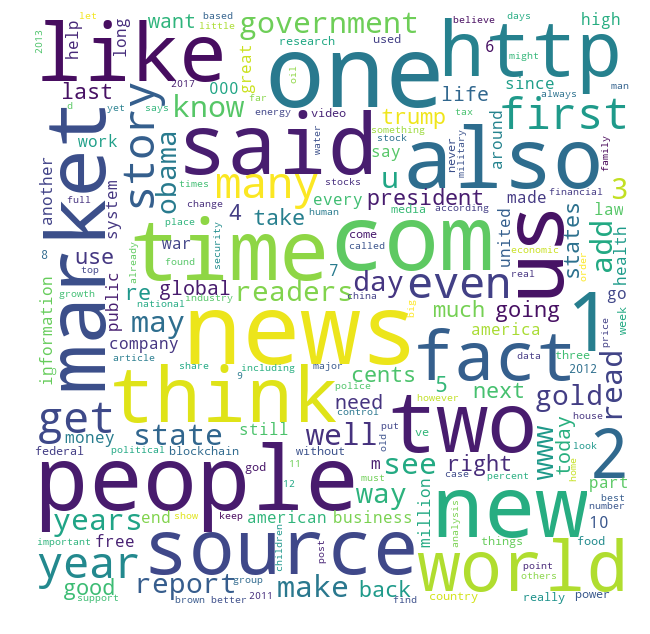

CPU times: user 515 ms, sys: 21.1 ms, total: 536 ms
Wall time: 1min 14s


In [9]:
%%time
wc_top_n = 200
# wordcloud for label 0
plot_wordcloud(get_word_freq(df_words, label='fake', column="words", top_n=wc_top_n), wc_top_n)

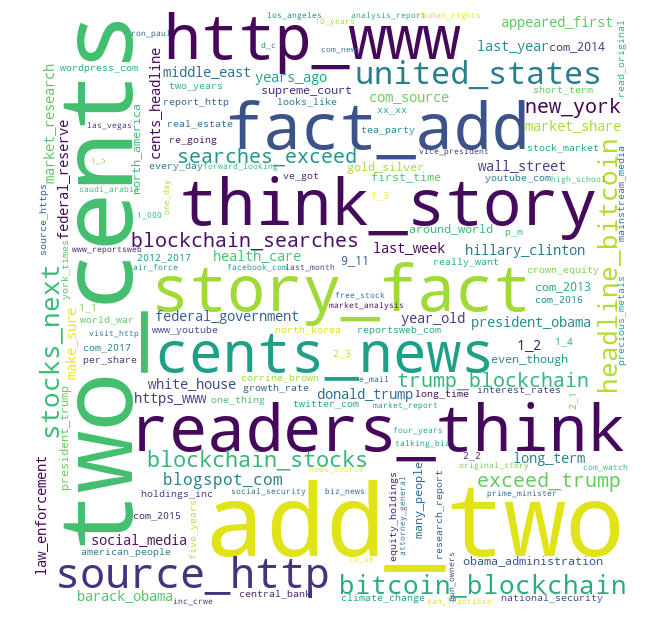

CPU times: user 505 ms, sys: 32.9 ms, total: 538 ms
Wall time: 7min 55s


In [ ]:
%%time
# 2gram wordcloud for label 0
plot_wordcloud(get_ngram_freq(df_words, n=2, label='fake', top_n=wc_top_n), wc_top_n)

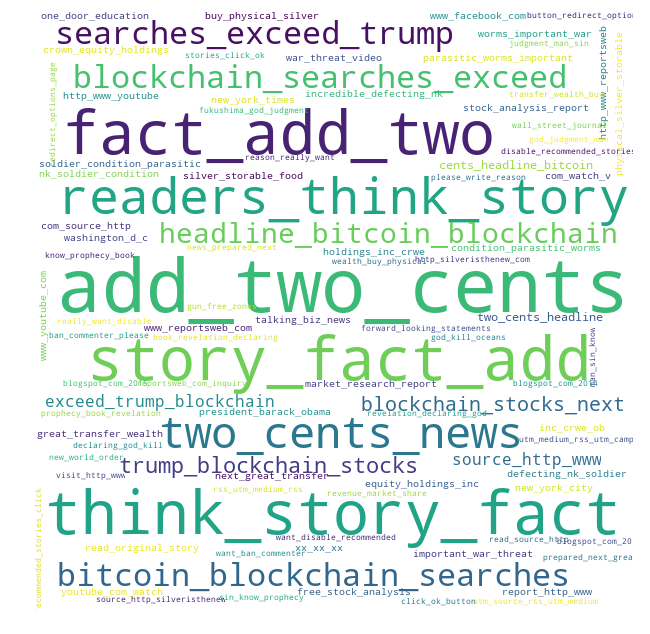

CPU times: user 528 ms, sys: 45.1 ms, total: 573 ms
Wall time: 10min 38s


In [ ]:
%%time
# 3gram wordcloud for label 0
plot_wordcloud(get_ngram_freq(df_words, n=3, label='fake', top_n=wc_top_n), wc_top_n)

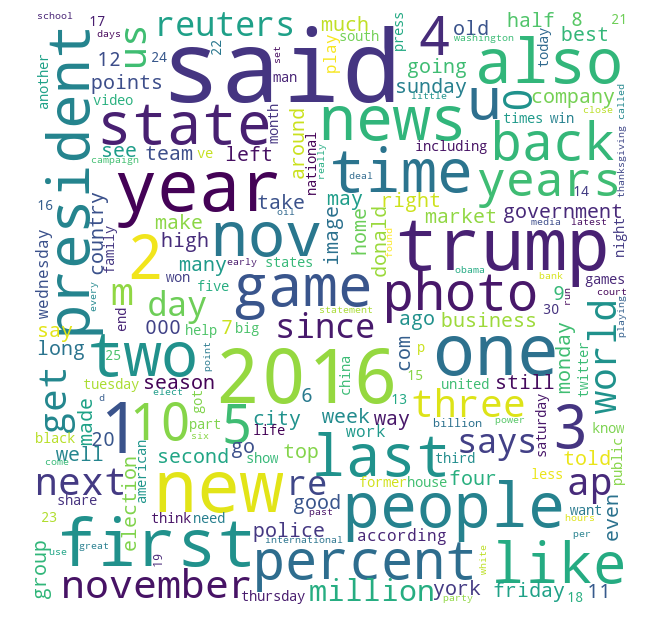

CPU times: user 462 ms, sys: 48.2 ms, total: 510 ms
Wall time: 34.2 s


In [ ]:
%%time
wc_top_n = 200
# wordcloud for label 0
plot_wordcloud(get_word_freq(df_words, label='reliable', column="words", top_n=wc_top_n), wc_top_n)

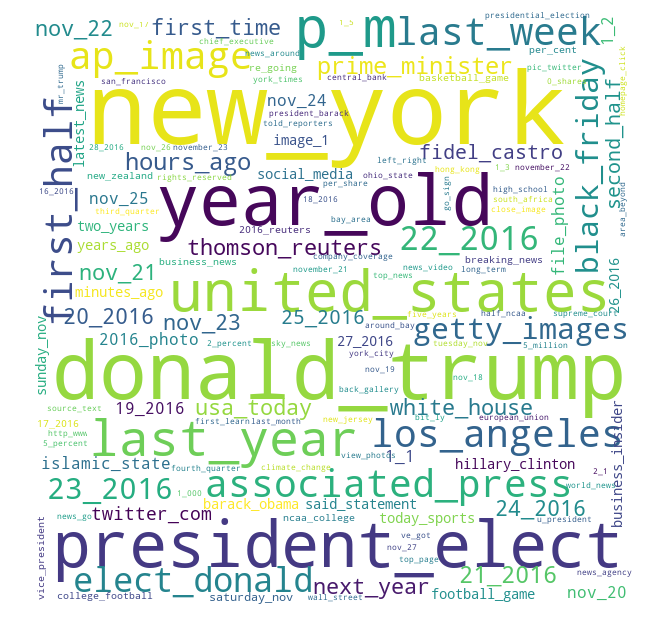

CPU times: user 456 ms, sys: 28 ms, total: 484 ms
Wall time: 3min 18s


In [ ]:
%%time
# 2gram wordcloud for label 0
plot_wordcloud(get_ngram_freq(df_words, n=2, label='reliable', top_n=wc_top_n), wc_top_n)

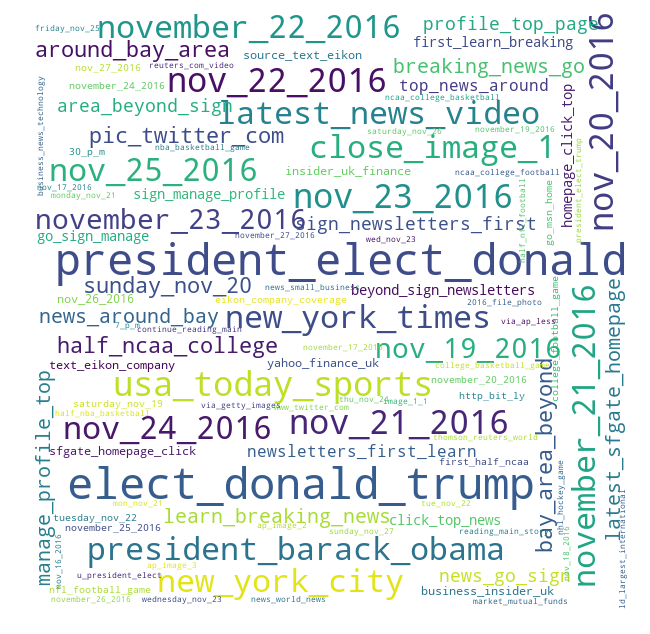

CPU times: user 514 ms, sys: 34.9 ms, total: 549 ms
Wall time: 9min 25s


In [ ]:
%%time
# 3gram wordcloud for label 0
plot_wordcloud(get_ngram_freq(df_words, n=3, label='reliable', top_n=wc_top_n), wc_top_n)